## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.


### Hypothesis Generation

Make it a practice to do this before solving any ML problem. 
Ideally,before seeing the data or else, you might end up with biased hypotheses.

What could affect the target variable (sales)?

1. Time of week : Weekends usually are more busy
2. Time of day  : Higher sales in the mornings and late evenings
3. Time of year : Higher sales at end of the year 
4. Store size and location
5. Items with more shelf space

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV

In [199]:
df = pd.read_csv(r"C:\Users\Asus\Documents\Dataset\Bigmart\bigmart_train.csv", low_memory=False)

In [200]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [201]:
df.shape

(8523, 12)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [203]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [204]:
df.isna().mean()

Item_Identifier              0.000000
Item_Weight                  0.171653
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282764
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Outlet_Sales            0.000000
dtype: float64

In [205]:
df.drop_duplicates(inplace=True)

<AxesSubplot:ylabel='Frequency'>

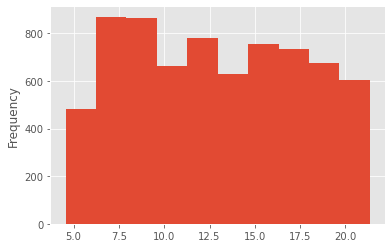

In [206]:
df['Item_Weight'].plot(kind='hist')

In [207]:
#filling missing cells of item_weight using grouped mean (grouping on item_type)
def fill_missing_cells_item_wt(cols):
    item_weight = cols[1]
    item_type = cols[0]
    if pd.isnull(item_weight):
        return df[df['Item_Type'] == item_type]['Item_Weight'].mean()
    else:
        return item_weight

In [208]:
df['Item_Weight'] = df[['Item_Type','Item_Weight']].apply(fill_missing_cells_item_wt, axis=1)

In [209]:
#filling missing cells of outlet size using outlet type(grouped mode)
def fill_missing_cells_outlet_size(cols):
    outlet_size = cols[1]
    outlet_type = cols[0]
    if pd.isnull(outlet_size):
        return df[df['Outlet_Type'] == outlet_type]['Outlet_Size'].mode()[0]
    else:
        return outlet_size

In [210]:
df['Outlet_Size'] = df[['Outlet_Type','Outlet_Size']].apply(fill_missing_cells_outlet_size, axis=1)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.6+ KB


In [212]:
for col in df.columns:
    print(col+' : '+str(df[col].nunique()))

Item_Identifier : 1559
Item_Weight : 431
Item_Fat_Content : 5
Item_Visibility : 7880
Item_Type : 16
Item_MRP : 5938
Outlet_Identifier : 10
Outlet_Establishment_Year : 9
Outlet_Size : 3
Outlet_Location_Type : 3
Outlet_Type : 4
Item_Outlet_Sales : 3493


In [213]:
df.drop(['Item_Identifier','Outlet_Identifier'], axis=1, inplace=True)

In [214]:
df_cat = df.select_dtypes('object')

In [215]:
df_cat.head()

,Item_Fat_Content,Item_Type,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,Low Fat,Dairy,Medium,Tier 1,Supermarket Type1
1,Regular,Soft Drinks,Medium,Tier 3,Supermarket Type2
2,Low Fat,Meat,Medium,Tier 1,Supermarket Type1
3,Regular,Fruits and Vegetables,Small,Tier 3,Grocery Store
4,Low Fat,Household,High,Tier 3,Supermarket Type1


In [216]:
for col in df_cat.columns:
    print(col + ' : ', df_cat[col].unique())

Item_Fat_Content :  ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type :  ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Size :  ['Medium' 'Small' 'High']
Outlet_Location_Type :  ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type :  ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [217]:
item_fat_1 = ['Low Fat', 'low fat', 'LF']
item_fat_2 = ['Regular', 'reg']
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(item_fat_1, 'LF')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(item_fat_2, 'reg')

In [218]:
df['Item_Fat_Content'].unique()

array(['LF', 'reg'], dtype=object)

In [219]:
df_num = df.select_dtypes('number')

In [220]:
df_num.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.50,0.016760,141.6180,1999,2097.2700
3,19.20,0.000000,182.0950,1998,732.3800
4,8.93,0.000000,53.8614,1987,994.7052


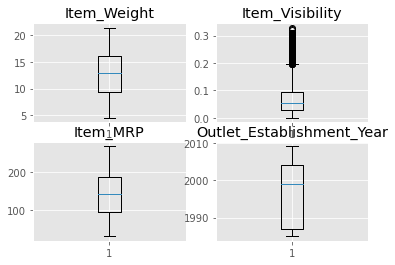

In [221]:
plt.subplot(2,2,1)
plt.boxplot(df['Item_Weight'])
plt.title('Item_Weight')

plt.subplot(2,2,2)
plt.boxplot(df['Item_Visibility'])
plt.title('Item_Visibility')

plt.subplot(2,2,3)
plt.boxplot(df['Item_MRP'])
plt.title('Item_MRP')

plt.subplot(2,2,4)
plt.boxplot(df['Outlet_Establishment_Year'])
plt.title('Outlet_Establishment_Year')
plt.show()

In [222]:
Q1 = df['Item_Visibility'].quantile(0.25)
Q3 = np.percentile(df['Item_Visibility'], 75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

In [223]:
df = df[(df['Item_Visibility']<=upper_bound) & (df['Item_Visibility']>=lower_bound)]

In [224]:
df['Item_Visibility'].min(), df['Item_Visibility'].max()

(0.0, 0.195721125)

In [225]:
df['Item_Visibility_cat'] = pd.cut(df['Item_Visibility'], [0,0.07,0.14,0.21], labels=['low', 'medium', 'high'], include_lowest=True)

In [226]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_cat
0,9.30,LF,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380,low
1,5.92,reg,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228,low
2,17.50,LF,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700,low
3,19.20,reg,0.000000,Fruits and Vegetables,182.0950,1998,Small,Tier 3,Grocery Store,732.3800,low
4,8.93,LF,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052,low


In [227]:
df.drop('Item_Visibility', axis=1, inplace=True)

In [228]:
#one hot encoding for Item_Type, Outlet_Type
#ordinal encoding for rest

In [229]:
nominal_col_list = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']
ordinal_col_list = ['Outlet_Size','Outlet_Location_Type','Item_Visibility_cat']

In [230]:
one_hot_df = pd.get_dummies(df[nominal_col_list],drop_first=True)

In [231]:
one_hot_df.head()

,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [232]:
enc = OrdinalEncoder()
ordinal_df = enc.fit_transform(df[ordinal_col_list])
ordinal_df = pd.DataFrame(ordinal_df, columns=ordinal_col_list)


In [233]:
ordinal_df.shape

(8379, 3)

In [234]:
ordinal_df.head()

,Outlet_Size,Outlet_Location_Type,Item_Visibility_cat
0,1.0,0.0,1.0
1,1.0,2.0,1.0
2,1.0,0.0,1.0
3,2.0,2.0,1.0
4,0.0,2.0,1.0


In [235]:
df.drop(nominal_col_list,axis=1,inplace=True)
df.drop(ordinal_col_list,axis=1,inplace=True)

In [236]:
df.reset_index(drop=True, inplace=True)
ordinal_df.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

In [237]:
df = pd.concat([df, one_hot_df, ordinal_df], axis=1)
df.head()

,Item_Weight,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Outlet_Location_Type,Item_Visibility_cat
0,9.30,249.8092,1999,3735.1380,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1.0,0.0,1.0
1,5.92,48.2692,2009,443.4228,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1.0,2.0,1.0
2,17.50,141.6180,1999,2097.2700,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1.0,0.0,1.0
3,19.20,182.0950,1998,732.3800,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,2.0,1.0
4,8.93,53.8614,1987,994.7052,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,2.0,1.0


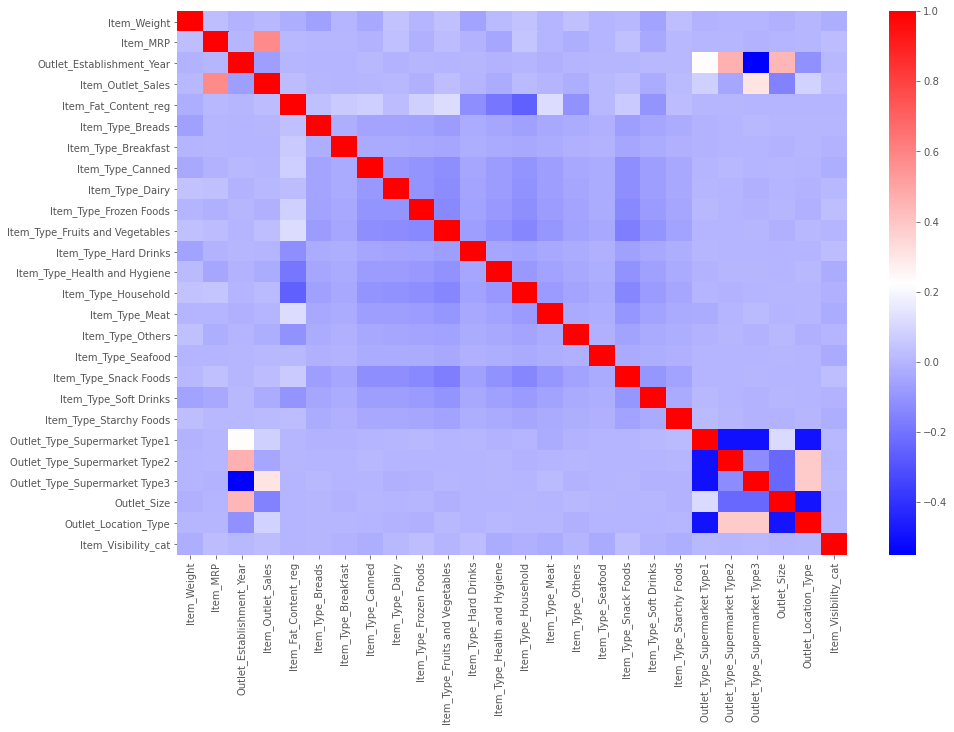

In [238]:
figure = plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='bwr')
plt.show()

In [239]:
#to get the index of null values
#df[df['Outlet_Size'].isnull()].index.tolist()

In [240]:
y = df['Item_Outlet_Sales']
X = df.drop(['Item_Outlet_Sales'], axis=1)

In [241]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=12)

In [242]:
X_train.shape, X_test.shape

((6703, 25), (1676, 25))

In [243]:
liner_model = LinearRegression()
liner_model.fit(X_train,y_train)

LinearRegression()

In [244]:
y_pred = liner_model.predict(X_test)

In [245]:
r2_score(y_test, y_pred), liner_model.score(X_train, y_train)

(0.5418151150204678, 0.5615750826983033)

In [246]:
mean_squared_error(y_test, y_pred)

1330381.3335183645

If the model is overfit (in this case it is not actually overfit)

Ridge Regression

In [247]:
ridge = Ridge()
parameters = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]} 
gscv = GridSearchCV(ridge, param_grid=parameters, cv=5, verbose=1)
gscv.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}, verbose=1)

In [248]:
gscv.best_params_, gscv.best_score_

({'alpha': 1}, 0.5570333002705927)

In [249]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [250]:
y_pred_ridge = ridge.predict(X_test)

In [251]:
r2_score(y_test, y_pred_ridge)

0.5419368964441889

Lasso Regression

In [252]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [253]:
lasso.score(X_train, y_train), lasso.score(X_test, y_test)

(0.5614203184548087, 0.5426468617062994)

In [254]:
parameters = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
gscv = GridSearchCV(lasso, param_grid=parameters, cv=3)
gscv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001]})

In [255]:
gscv.best_params_, gscv.best_score_

({'alpha': 1}, 0.5582337801667561)